## Dataset plotting

This is a notebook for plotting general dataset kinematics.

In [1]:
import sys, os, glob, uuid
import numpy as np
import ROOT as rt
import uproot as ur
from numba import jit
from pathlib import Path

path_prefix = os.getcwd() + '/../'
if(path_prefix not in sys.path): sys.path.append(path_prefix)
from util import ml_util as mu # for passing calo images to regression networks
from util import qol_util as qu # for progress bar
from util import jet_util as ju

Welcome to JupyROOT 6.22/02


In [31]:
plotpath = path_prefix + 'jets/clusterPlots/'

In [2]:
plotstyle = qu.PlotStyle('dark')
plotstyle.SetStyle()

## Plotting average images.

Let's plot average cluster images, from two different datasets.

Specifically, as one of our datasets contains *labeled* topo-clusters and the other contains *unlabeled* topo-clusters, we're going to apply some classifier and then consider its output categories. This way everything is compared on an equal footing. We want to see if there are noticeable differences between images in our training/calibration dataset (single pions), and our dijet samples.

In [3]:
# ----- Calorimeter meta-data -----
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
nlayers = len(layers)
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]
assert(len(len_phi) == nlayers)
assert(len(len_eta) == nlayers)
meta_data = {
    layers[i]:{
        'cell_size':(cell_size_eta[i],cell_size_phi[i]),
        'dimensions':(len_eta[i],len_phi[i])
    }
    for i in range(nlayers)
}

In [4]:
data = {}

data_dir = {
    'pion':path_prefix + 'data/pion',
    'jet' :path_prefix + 'data/jet'
}

In [5]:
tree_name = 'ClusterTree'
data_files = {key:glob.glob(val + '/*.root') for key,val in data_dir.items()}

In [6]:
# debugging
#data_files['jet'] = data_files['jet'][:2]

In [7]:
data_trees = {
    key:[ur.open(x)[tree_name] for x in val]
    for key,val in data_files.items()
}

In [8]:
# load calo image for both datasets into a dictionary, for easy access

l = len(data_files.keys()) * len(layers)
prefix = 'Loading calo images:'
suffix = 'Complete'
bl = 50
i = 0
qu.printProgressBarColor(i, l, prefix=prefix, suffix=suffix, length=bl)
    
calo_images = {}
for key, trees in data_trees.items():
    calo_images[key] = {}
    for layer in layers:
        calo_images[key][layer] = np.row_stack([tree.array(layer) for tree in trees])
        i+=1
        qu.printProgressBarColor(i, l, prefix=prefix, suffix=suffix, length=bl)

Loading calo images: |██████████████████████████████████████████████████| 100.0% Complete


In [9]:
# also load the topo-cluster energies, for making cuts
eng_calib_tot = {key: np.concatenate([tree.array('cluster_ENG_CALIB_TOT') for tree in trees]) 
                 for key,trees in data_trees.items()
}

Now, we want to compute network scores (classification) for the topo-clusters. We'll pick clusters that have a very high or very low score (i.e. ones whose identities we are relatively confident about).

In [10]:
# Imports and setup for TensorFlow and Keras.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disable some of the tensorflow info printouts, only display errors
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

ngpu = 1
gpu_list = ["/gpu:"+str(i) for i in range(ngpu)]
strategy = tf.distribute.MirroredStrategy(devices=gpu_list)
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [14]:
classification_dir = path_prefix + 'classifier/Models'

In [15]:
network_models = {}
# flat classifiers
print('Loading flat classification models... ')
flat_model_files = glob.glob(classification_dir + '/flat/' + '*.h5')
flat_model_files.sort()
flat_model_names = []
for model in flat_model_files:
    model_name = model.split('model_')[-1].split('_flat')[0]
    print('\tLoading ' + model_name + '... ',end='')
    flat_model_names.append(model_name)
    network_models[model_name] = tf.keras.models.load_model(model)
    print('Done.')

# combo classifier
print('Loading simple combo classification model... ',end='')
combo_model_file = classification_dir + '/simple/' + 'model_simple.h5'
network_models['combo'] = tf.keras.models.load_model(combo_model_file)
print('Done.')

Loading flat classification models... 
	Loading EMB1... Done.
	Loading EMB2... Done.
	Loading EMB3... Done.
	Loading TileBar0... Done.
	Loading TileBar1... Done.
	Loading TileBar2... Done.
Loading simple combo classification model... Done.


Now let's compute scores. Note that this involves using the calorimeter images, but in a slightly different format than above. We can get the right shape by using `mu.setupCells()`, or by simply flattening our existing images (so that they go from 3D arrays to 2D arrays).

In [16]:
l = len(data_trees) * (3 + len(layers))
prefix = 'Evaluating classification network:'
suffix = 'Complete'
bl = 50
i = 0
qu.printProgressBarColor(i, l, prefix=prefix, suffix=suffix, length=bl)
 
scores = {}
for key in data_trees.keys():
    combined_images = np.concatenate([calo_images[key][layer].reshape(calo_images[key][layer].shape[0],-1) for layer in layers],axis=1)
    i += 1
    qu.printProgressBarColor(i, l, prefix=prefix, suffix=suffix, length=bl)
    s_combined = mu.standardCells(combined_images, layers)[0]
    i += 1
    qu.printProgressBarColor(i, l, prefix=prefix, suffix=suffix, length=bl)
    
    del combined_images
    
    flat_scores = {}
    for layer in layers:
        model = network_models[layer]
        flat_scores[layer] = model.predict(calo_images[key][layer].reshape(calo_images[key][layer].shape[0],-1))[:,1]
        i += 1
        qu.printProgressBarColor(i, l, prefix=prefix, suffix=suffix, length=bl)
    
    model = network_models['combo']
    input_scores = np.column_stack([flat_scores[layer] for layer in layers])
    del flat_scores
    scores[key] = model.predict(input_scores)[:,1] # likelihood of being charged pion (versus neutral pion)
    i += 1
    qu.printProgressBarColor(i, l, prefix=prefix, suffix=suffix, length=bl)

Evaluating classification network: |██████████████████████████████████████████████████| 100.0% Complete


Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/jets/../jets/clusterPlots/scores.png has been created


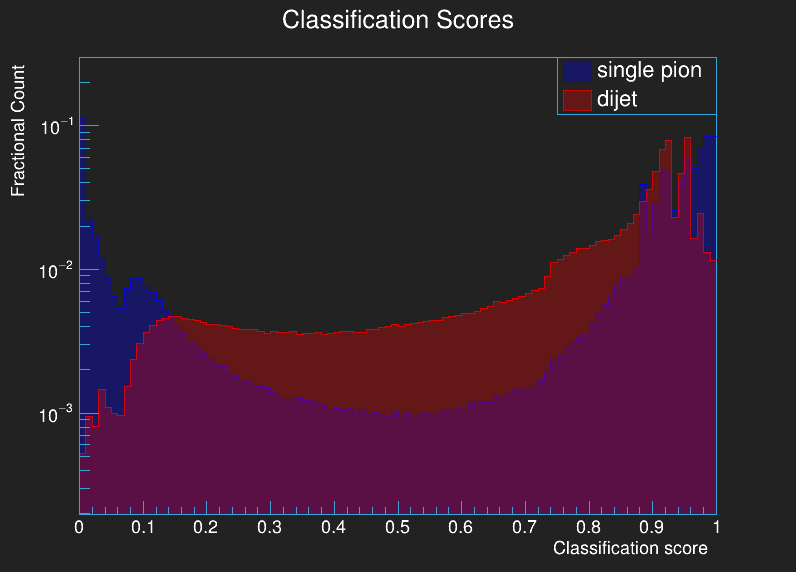

In [34]:
rt.gStyle.SetOptStat(0)
c = rt.TCanvas(qu.RN(),'score',800,600)

h = {key:rt.TH1F(qu.RN(), ';Classification Score;Count',100,0.,1.) for key in scores.keys()}
colors = {'pion':rt.kBlue,'jet':rt.kRed}

legend_entries ={
    'pion':'single pion',
    'jet':'dijet'
}

for key,hist in h.items(): 
    hist.SetLineColorAlpha(colors[key],0.7)
    hist.SetFillColorAlpha(colors[key],0.3)
    for element in scores[key]: hist.Fill(element)
    hist.Scale(1. / hist.Integral())
    
hstack = rt.THStack()
legend = rt.TLegend(0.7,0.8,0.9,0.9)
legend.SetTextColor(plotstyle.text)

for key,hist in h.items():
    hstack.Add(hist)
    legend.AddEntry(hist,legend_entries[key],'f')

hstack.Draw('NOSTACK HIST')
hstack.SetMaximum(.3)
hstack.SetTitle('Classification Scores')
hstack.GetXaxis().SetTitle('Classification score')
hstack.GetYaxis().SetTitle('Fractional Count')

legend.Draw()
rt.gPad.SetLogy()
c.Draw()
c.SaveAs(plotpath + 'scores.png')

For each dataset, let's define indices of clusters in which we're interested. To free up some memory -- in case that's a concern at this point -- we can drop events that don't pass our classification score selection.

We will pick clusters with very low or high scores, as these are the clusters of whose identities our classification network is most sure. Note that the distributions are rather different between datasets -- our classification is reporting a higher proportion of likely neutral pions in the `pion` dataset than in our `jet` dataset.

Note that we will also want to compare the datasets within some relatively narrow band of energies, as their energy distributions will likely be quite different.

Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/jets/../jets/clusterPlots/eng_calib_tot.png has been created


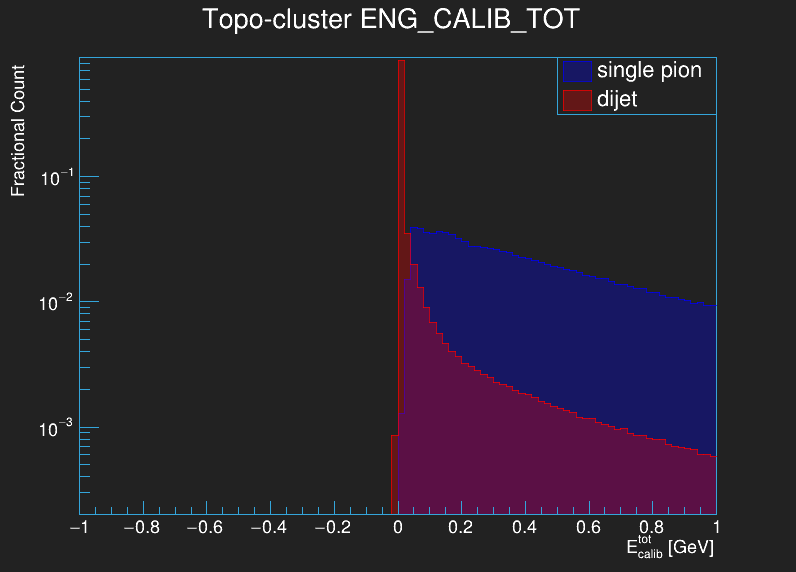

In [50]:
rt.gStyle.SetOptStat(0)
c = rt.TCanvas(qu.RN(),'score',800,600)

h = {key:rt.TH1F(qu.RN(), ';E_{calib}^{tot};Count',100,-1.,1.) for key in scores.keys()}

for key,hist in h.items(): 
    hist.SetLineColorAlpha(colors[key],0.7)
    hist.SetFillColorAlpha(colors[key],0.3)
    for element in eng_calib_tot[key]: hist.Fill(element)
    hist.Scale(1. / hist.Integral())
    
hstack = rt.THStack()
legend = rt.TLegend(0.7,0.8,0.9,0.9)
legend.SetTextColor(plotstyle.text)

for key,hist in h.items():
    hstack.Add(hist)
    legend.AddEntry(hist,legend_entries[key],'f')

hstack.Draw('NOSTACK HIST')
hstack.SetMaximum(.9)
hstack.SetTitle('Topo-cluster ENG_CALIB_TOT')
hstack.GetXaxis().SetTitle('E_{calib}^{tot} [GeV]')
hstack.GetYaxis().SetTitle('Fractional Count')

legend.Draw()
rt.gPad.SetLogy()
c.Draw()
c.SaveAs(plotpath + 'eng_calib_tot.png')

In [61]:
print(eng_calib_tot['jet'][eng_calib_tot['jet'] < 0.])
print(np.sum(eng_calib_tot['jet'] == 0.))
print(np.sum(eng_calib_tot['jet'] == 0.) / eng_calib_tot['jet'].shape[0])

[-0.00587719 -0.00359891 -0.00411078 ... -0.00526817 -0.00300617
 -0.00668481]
853251
0.3674766432420769


In [35]:
score_threshold = 1. # take clusters with score< score_threshold, OR score > 1. - score_threshold (default is 0.05)
energy_window = (-1.,0.) # GeV (default is (9.,10.))

#TODO: Use energy window cut in cluster_indices

cluster_indices = {}
for key in scores.keys():
    
    energy_selection = (eng_calib_tot[key] > energy_window[0]) * (eng_calib_tot[key] < energy_window[1])
    score_selection  = (scores[key] < score_threshold) + (scores[key] > 1. - score_threshold)
    combined_selection = energy_selection * score_selection
    cluster_indices[key] = np.where(combined_selection)[0]

In [36]:
# apply our cluster_indices to the data -- for now we make new variables instead of overwriting
calo_images_selected = {key:{
    layer:images[cluster_indices[key]]
    for layer,images in val.items()
    }
for key,val in calo_images.items()
}

eng_calib_tot_selected = {key:val[cluster_indices[key]] for key,val in eng_calib_tot.items()}
scores_selected = {key:val[cluster_indices[key]] for key,val in scores.items()}

In [37]:
charged_indices = {key:np.where(scores_selected[key] > 1. - score_threshold)[0] for key in scores.keys()}
neutral_indices = {key:np.where(scores_selected[key] < score_threshold)[0] for key in scores.keys()}

For each calo layer, we want to compare images from the two datasets. So we will make average images for each dataset, as well as the difference between the averages.

In [38]:
#TODO: Image2Arrays is broken. 
@jit
def Image2Arrays(image, x_range, y_range):
    nx, ny = image.shape
    dx = (x_range[1] - x_range[0]) / nx
    dy = (y_range[1] - y_range[0]) / ny
    
    # list of bin centers in x, y
    x_vals = np.linspace(x_range[0] + dx/2, x_range[1] - dx/2, nx)
    y_vals = np.linspace(y_range[0] + dy/2, y_range[1] - dy/2, ny)
    
    # now get full list of x,y and w (weights)
    x = np.repeat(x_vals,ny).reshape(-1,ny).T.flatten() # like np.tile() but numba-friendly
    y = np.repeat(y_vals,nx)
    w = image.flatten()
    return x,y,w

def FillImage(h, image, x_range, y_range, upper=True):
    
    if(upper): image = np.flip(image,axis=0)
    x,y,w = Image2Arrays(image, x_range, y_range)
    N = len(x)
    for i in range(N):
        h.Fill(x[i],y[i],w[i])
    
    if(np.sum(w) != 0.):
        
        if(np.random.rand() > 0.95):
            a = np.column_stack((x,y,w))
            print('\n')
            for entry in a: print(entry)
            print('\n\n')
            for row in image: print(row)
            print('---------')
   
    h.FillN(N,x.astype('float'),y.astype('float'),w.astype('float'))
    return

In [39]:
# convenience function

def ImageDraw(h,N,plot_min,plot_max,n_eta,n_phi):
    N = np.maximum(N,1) # in case of N = 0, i.e. no images
    h.Scale(1./N)
    h.Draw('COLZ')
    h.SetMinimum(plot_min)
    h.SetMaximum(plot_max)
    
    if(n_eta > 32): n_eta = int(n_eta / 16)
    elif(n_eta > 8): n_eta = int(n_eta / 4)
    if(n_phi > 8): n_phi = int(n_phi / 4)
    
    h.GetXaxis().SetNdivisions(-n_eta)
    h.GetYaxis().SetNdivisions(-n_phi)
    
    rt.gPad.SetGrid()

EMB1     : |██████████████████████████████████████████████████| 100.0% Complete
EMB2     : |██████████████████████████████████████████████████| 100.0% Complete
EMB3     : |██████████████████████████████████████████████████| 100.0% Complete
TileBar0 : |██████████████████████████████████████████████████| 100.0% Complete
TileBar1 : |██████████████████████████████████████████████████| 100.0% Complete
TileBar2 : |██████████████████████████████████████████████████| 100.0% Complete


Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/jets/../jets/comparison.png has been created


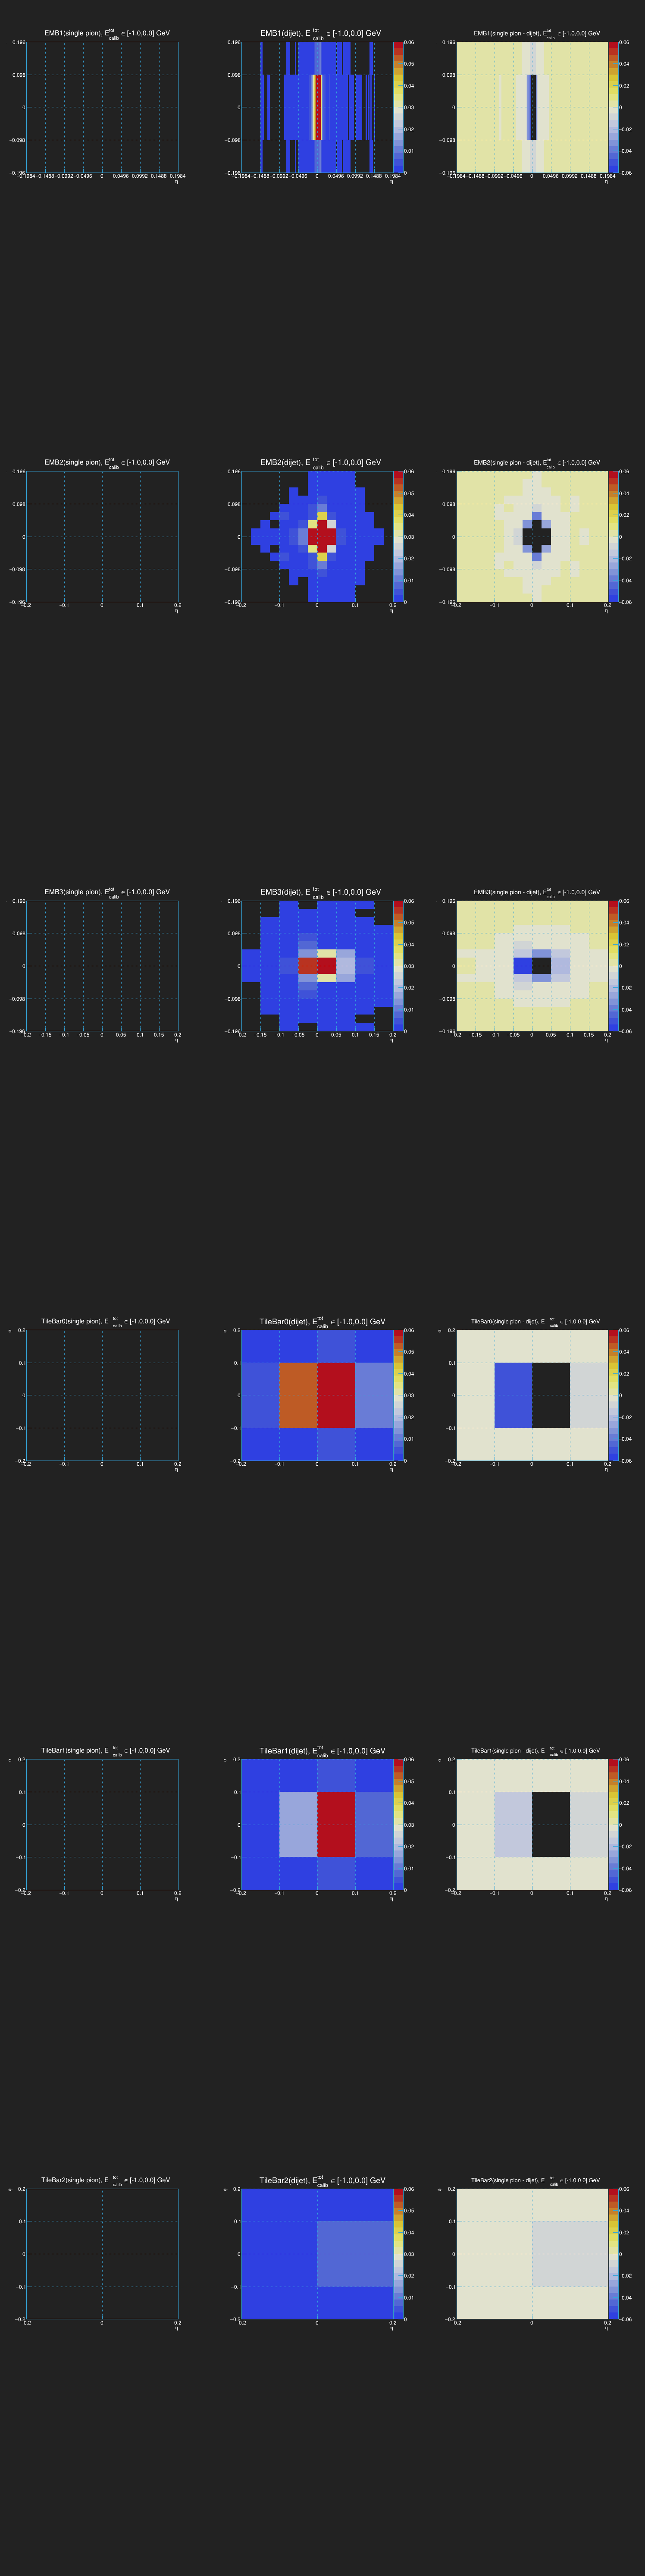

In [47]:
rt.gStyle.SetOptStat(0)
rt.gStyle.SetPalette(rt.kTemperatureMap)

nx = 3
ny = len(layers) * 2
plot_size = 500
plot_min, plot_max = (0.,0.06)
right_margin = 0.15

c = rt.TCanvas(qu.RN(),'avg_images', nx * plot_size, ny * plot_size)
c.Divide(nx, ny)

hists = [] # keep a list of histogram objects

for i,layer in enumerate(layers):
    
    prefix = '{:<9}:'.format(layer)
    suffix = 'Complete'
    bl = 50
    k = 0
    l=6
    qu.printProgressBarColor(k, l, prefix=prefix, suffix=suffix, length=bl)
    
    n_eta, n_phi  = meta_data[layer]['dimensions']
    dims = (n_eta,n_phi)
    csize = meta_data[layer]['cell_size']
    
    eta_min = - dims[0] * csize[0] / 2
    eta_max = - eta_min
    eta_range = (eta_min, eta_max)
    
    phi_min = - dims[1] * csize[1] / 2
    phi_max = - phi_min
    phi_range = (phi_min, phi_max)
    
    # --- Neutral pions ---
    
    # average image for pion dataset
    c.cd(1 + 6*i) # 1-indexing for pads
    rt.gPad.SetRightMargin(right_margin)
    
    title = layer + '(#pi^{0}, single pion)' + ', E_{calib}^{tot} #in ' + '[{:.1f},{:.1f}] GeV'.format(*energy_window) + ';#eta;#phi'
    if(score_threshold == 1.): title=title.replace('#pi^{0}, ','')
    
    h1 = rt.TH2F(qu.RN(), title,n_eta,eta_min,eta_max,n_phi,phi_min,phi_max)
    N = 0
    for image in calo_images_selected['pion'][layer][neutral_indices['pion']]:
        N += 1
        if(np.sum(image) == 0.): continue
        [[h1.SetBinContent(i+1,n_phi-j,h1.GetBinContent(i+1,j+1) + image[i,j]) for i in range(n_eta)] for j in range(n_phi)]
        #FillImage(h1,image,eta_range,phi_range)
    ImageDraw(h1,N,plot_min,plot_max,n_eta,n_phi)
    
    k += 1
    qu.printProgressBarColor(k, l, prefix=prefix, suffix=suffix, length=bl)
    
    # average image for jet dataset
    c.cd(1 + 6*i + 1)
    rt.gPad.SetRightMargin(right_margin)

    title = layer + '(#pi^{0}, dijet)' + ', E_{calib}^{tot} #in ' + '[{:.1f},{:.1f}] GeV'.format(*energy_window) + ';#eta;#phi'
    if(score_threshold == 1.): title=title.replace('#pi^{0}, ','')
    h2 = rt.TH2F(qu.RN(), title,dims[0],eta_min,eta_max,dims[1],phi_min,phi_max)
    N = 0
    for image in calo_images_selected['jet'][layer][neutral_indices['jet']]:
        N += 1
        if(np.sum(image) == 0.): continue
        [[h2.SetBinContent(i+1,n_phi-j,h2.GetBinContent(i+1,j+1) + image[i,j]) for i in range(n_eta)] for j in range(n_phi)]     
    ImageDraw(h2,N,plot_min,plot_max,n_eta,n_phi)
    
    k += 1
    qu.printProgressBarColor(k, l, prefix=prefix, suffix=suffix, length=bl)
    
    # difference between average images, pion - jet
    c.cd(1 + 6*i + 2)
    rt.gPad.SetRightMargin(right_margin)
    
    h3 = h1.Clone()
    h3.Add(h2, -1.)
    title = layer + '(#pi^{0}, single pion - dijet)' + ', E_{calib}^{tot} #in ' + '[{:.1f},{:.1f}] GeV'.format(*energy_window) + ';#eta;#phi'
    if(score_threshold == 1.): title=title.replace('#pi^{0}, ','')
    h3.SetTitle(title)
    ImageDraw(h3,1,-plot_max,plot_max,n_eta,n_phi)
    k += 1
    qu.printProgressBarColor(k, l, prefix=prefix, suffix=suffix, length=bl)
    
    hists.append(h1)
    hists.append(h2)
    hists.append(h3)

    # --- Charged pions ---
    if(score_threshold == 1.): 
        qu.printProgressBarColor(l, l, prefix=prefix, suffix=suffix, length=bl)
        continue

    # average image for pion dataset
    c.cd(1 + 6*i + 3) # 1-indexing for pads
    rt.gPad.SetRightMargin(right_margin)

    h1 = rt.TH2F(qu.RN(), layer + '(#pi^{#pm}, single pion);#eta;#phi',dims[0],eta_min,eta_max,dims[1],phi_min,phi_max)
    N = 0
    for image in calo_images_selected['pion'][layer][charged_indices['pion']]:
        N += 1
        if(np.sum(image) == 0.): continue
        [[h1.SetBinContent(i+1,n_phi-j,h1.GetBinContent(i+1,j+1) + image[i,j]) for i in range(n_eta)] for j in range(n_phi)]     
    ImageDraw(h1,N,plot_min,plot_max,n_eta,n_phi)

    k += 1
    qu.printProgressBarColor(k, l, prefix=prefix, suffix=suffix, length=bl)
    
    # average image for jet dataset
    c.cd(1 + 6*i + 4)
    rt.gPad.SetRightMargin(right_margin)

    h2 = rt.TH2F(qu.RN(), layer + '(#pi^{#pm}, djijet);#eta;#phi',dims[0],eta_min,eta_max,dims[1],phi_min,phi_max)
    N = 0
    for image in calo_images_selected['jet'][layer][charged_indices['jet']]:
        N += 1
        if(np.sum(image) == 0.): continue
        [[h2.SetBinContent(i+1,n_phi-j,h2.GetBinContent(i+1,j+1) + image[i,j]) for i in range(n_eta)] for j in range(n_phi)]     
        #FillImage(h2, image, eta_range,phi_range)
    ImageDraw(h2,N,plot_min,plot_max,n_eta,n_phi)

    k += 1
    qu.printProgressBarColor(k, l, prefix=prefix, suffix=suffix, length=bl)
    
    # difference between average images, pion - jet
    c.cd(1 + 6*i + 5)
    rt.gPad.SetRightMargin(right_margin)

    h3 = h1.Clone()
    h3.Add(h2, -1.)
    h3.SetTitle(layer + '(#pi^{#pm}, single pion - dijet);#eta;#phi')
    ImageDraw(h3,1,-plot_max,plot_max,n_eta,n_phi)
    
    k += 1
    qu.printProgressBarColor(k, l, prefix=prefix, suffix=suffix, length=bl)
    
    hists.append(h1)
    hists.append(h2)
    hists.append(h3)
    
c.Draw()

c.SaveAs(path_prefix + 'jets/comparison.png')
#c.SaveAs(path_prefix + 'jets/comparison.pdf')